# Part One

In [3]:
#Basic libraries
import os
import re
import pandas as pd
import numpy as np

from sklearn.base import TransformerMixin

from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     cross_val_score)
    
from sklearn.preprocessing import (LabelBinarizer,
                                   StandardScaler,
                                   LabelEncoder)

from sklearn.pipeline import Pipeline

#Regressors
from sklearn.linear_model import (Ridge,
                                  Lasso,
                                  LinearRegression,
                                  LogisticRegression)

#Evaluation metrics
from sklearn.metrics import (confusion_matrix, 
                             classification_report, 
                             roc_auc_score,
                             roc_curve,
                             accuracy_score,
                             r2_score,
                             mean_squared_error, 
                             mean_absolute_error,
                             make_scorer)

#Ensemble classifiers        
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#PCA and LDA
from sklearn.decomposition import (PCA)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn_pandas import DataFrameMapper

#Univariate feature selection
from sklearn.feature_selection import (SelectKBest,
                                       chi2,
                                       f_classif,
                                       mutual_info_classif)

#Graphic libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
import seaborn as sns
import altair as alt
alt.renderers.enable('notebook')

from scipy.stats import ttest_ind, levene

import warnings
warnings.filterwarnings('ignore')

### Load the data and field names 

In [4]:
cancer_df = pd.read_csv('./data/breast-cancer.csv', header=None)
field_name = pd.read_csv('./data/field_names.txt', header=None, names=['name'])
cancer_df.columns = field_name['name'].tolist()

In [5]:
cancer_df.head()

,ID,diagnosis,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,...,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Checking for missing data

In [6]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
ID                            569 non-null int64
diagnosis                     569 non-null object
radius_mean                   569 non-null float64
radius_sd_error               569 non-null float64
radius_worst                  569 non-null float64
texture_mean                  569 non-null float64
texture_sd_error              569 non-null float64
texture_worst                 569 non-null float64
perimeter_mean                569 non-null float64
perimeter_sd_error            569 non-null float64
perimeter_worst               569 non-null float64
area_mean                     569 non-null float64
area_sd_error                 569 non-null float64
area_worst                    569 non-null float64
smoothness_mean               569 non-null float64
smoothness_sd_error           569 non-null float64
smoothness_worst              569 non-null float64
compactness_mean              5

### Number of samples in each class

In [7]:
cancer_df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

## Bootstrap samples

In [8]:
cancer_df.sample(n=10, replace = True)

,ID,diagnosis,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,...,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
508,915452,B,16.300,15.70,104.70,819.8,0.09427,0.06712,0.055260,0.045630,...,17.32,17.76,109.80,928.2,0.1354,0.13610,0.19470,0.13570,0.2300,0.07230
275,8911164,B,11.890,17.36,76.20,435.6,0.12250,0.07210,0.059290,0.074040,...,12.40,18.99,79.46,472.4,0.1359,0.08368,0.07153,0.08946,0.2220,0.06033
93,862009,B,13.450,18.30,86.60,555.1,0.10220,0.08165,0.039740,0.027800,...,15.10,25.94,97.59,699.4,0.1339,0.17510,0.13810,0.07911,0.2678,0.06603
14,84667401,M,13.730,22.61,93.60,578.3,0.11310,0.22930,0.212800,0.080250,...,15.03,32.01,108.80,697.7,0.1651,0.77250,0.69430,0.22080,0.3596,0.14310
21,8510824,B,9.504,12.44,60.34,273.9,0.10240,0.06492,0.029560,0.020760,...,10.23,15.66,65.13,314.9,0.1324,0.11480,0.08867,0.06227,0.2450,0.07773
96,86211,B,12.180,17.84,77.79,451.1,0.10450,0.07057,0.024900,0.029410,...,12.83,20.92,82.14,495.2,0.1140,0.09358,0.04980,0.05882,0.2227,0.07376
332,897132,B,11.220,19.86,71.94,387.3,0.10540,0.06779,0.005006,0.007583,...,11.98,25.78,76.91,436.1,0.1424,0.09669,0.01335,0.02022,0.3292,0.06522
171,87163,M,13.430,19.63,85.84,565.4,0.09048,0.06288,0.058580,0.034380,...,17.98,29.87,116.60,993.6,0.1401,0.15460,0.26440,0.11600,0.2884,0.07371
12,846226,M,19.170,24.80,132.40,1123.0,0.09740,0.24580,0.206500,0.111800,...,20.96,29.94,151.70,1332.0,0.1037,0.39030,0.36390,0.17670,0.3176,0.10230
448,911150,B,14.530,19.34,94.25,659.7,0.08388,0.07800,0.088170,0.029250,...,16.30,28.39,108.10,830.5,0.1089,0.26490,0.37790,0.09594,0.2471,0.07463


## Comparing mean and median for compactness and smoothness features

In [9]:
#Getting the features names
feature_names = cancer_df.columns.difference(['ID','diagnosis'])

#Label
labels = cancer_df['diagnosis']

#Extracting the compactness and smoohness fields
compactness_smoothness_features = [c for c in feature_names if ('compactness' in c or 'smoothness' in c)]

#Grouping by the label
cancer_classes_g = cancer_df[compactness_smoothness_features].groupby(labels)

#Printing mean and median
cancer_classes_g.agg(['mean','median'])

compactness_mean          compactness_sd_error            \
                      mean   median                 mean    median   
diagnosis                                                            
B                 0.021438  0.01631             0.025997  0.018400   
M                 0.032281  0.02859             0.041824  0.037125   

          compactness_worst           smoothness_mean          \
                       mean    median            mean  median   
diagnosis                                                       
B                  0.009858  0.009061        2.000321  1.8510   
M                  0.015060  0.014205        4.323929  3.6795   

          smoothness_sd_error         smoothness_worst            
                         mean  median             mean    median  
diagnosis                                                         
B                   21.135148  19.630         0.007196  0.006530  
M                   72.672406  58.455         0.006780  0.006209

#### Welch’s t-test independent to check  if the means of 'M' and 'B' is statistically different for the compactness and smoothness feaures

In [11]:
#Seperting the compactness and smoothness data by the lable 'M' and 'B'
m_comp_smooth_group = cancer_classes_g.get_group('M')
b_comp_compact_group = cancer_classes_g.get_group('B')


t_value, p_value = [], []
for f in compactness_smoothness_features:
    t, p = ttest_ind(m_comp_smooth_group[f], b_comp_compact_group[f], equal_var=False)
    t_value.append(t)
    p_value.append(p)

pd.DataFrame({'t_value':t_value, 'p_value':p_value}, index=compactness_smoothness_features)

,t_value,p_value
compactness_mean,7.082641,6.341807e-12
compactness_sd_error,6.916305,1.266514e-11
compactness_worst,10.735452,4.042197e-24
smoothness_mean,12.832763,6.868553e-29
smoothness_sd_error,12.155556,2.983568e-26
smoothness_worst,-1.622869,1.052970e-01


Except for smoothness_worst feature, the t-value is bigger than one and the p-value is less than 5% which indicates that the means for compactness and smoothness are significantly different between the two classes. For the smoothness_worst feature the p-value is larger than 10%, thus the null hypothesis that the means of 'M' and 'B' are equal (similar) is more strong.

## Exploratory data analysis

### Splitting into training and testing groups

In [12]:
y = cancer_df['diagnosis']
X = cancer_df[feature_names]

#Encoding the classes as integer, B = 0, M = 1
le = LabelEncoder()
y  = le.fit_transform(y)

#Splitting the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1000)

## Most three predictive variables using mutual information test
mutual_info_classif from sklearn is used to get a score for the importance of the features then select the top three features. mutual_info_classif returns the estimated mutual information between each feature and the target, higher values means higher dependancy. 

In [13]:
feature_scores = mutual_info_classif(X,y)
features_scored = list(zip(feature_names, feature_scores))

#sorting based on the heighest score
features_scored = sorted(features_scored, key=lambda x:x[1], reverse=True)

#The three top features
predictive_features = [f for f,_ in features_scored[0:3]]

for f, s in features_scored:
    print(f, ': score=%0.2f' %s)

concave_points_sd_error : score=0.48
concave_points_worst : score=0.46
concavity_worst : score=0.45
perimeter_sd_error : score=0.44
fractal_dimension_mean : score=0.44
radius_worst : score=0.40
perimeter_mean : score=0.38
radius_mean : score=0.37
texture_mean : score=0.36
smoothness_sd_error : score=0.34
symmetry_worst : score=0.32
smoothness_mean : score=0.28
area_sd_error : score=0.25
symmetry_sd_error : score=0.22
texture_worst : score=0.21
compactness_worst : score=0.13
concave_points_mean : score=0.12
compactness_sd_error : score=0.12
symmetry_mean : score=0.10
radius_sd_error : score=0.10
fractal_dimension_sd_error : score=0.09
texture_sd_error : score=0.08
compactness_mean : score=0.08
fractal_dimension_worst : score=0.07
perimeter_worst : score=0.07
concavity_sd_error : score=0.04
smoothness_worst : score=0.02
concavity_mean : score=0.01
area_mean : score=0.01
area_worst : score=0.00


### Plotting the density distribution of the the three most predictive features 

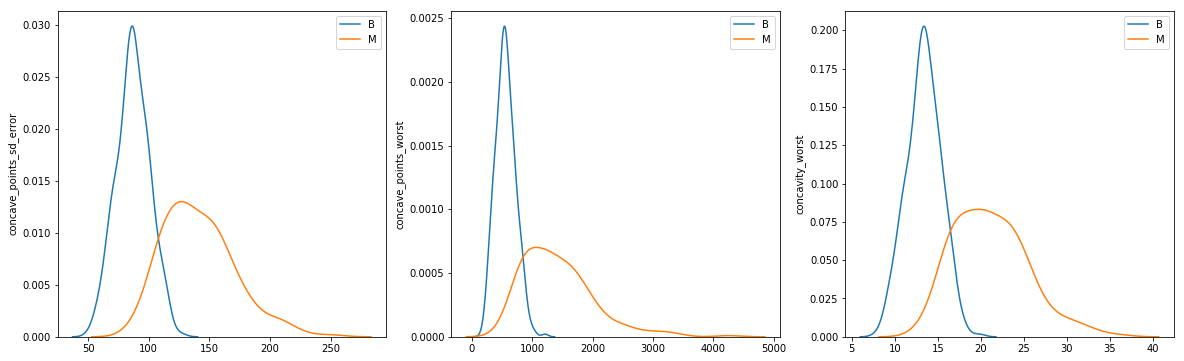

In [14]:
fig, axs = plt.subplots(1,3, figsize=(20, 6), facecolor='w', edgecolor='k')
i = 0
for f in predictive_features:
    b = sns.kdeplot(cancer_df[cancer_df['diagnosis']=='B'][f], ax = axs[i])
    m = sns.kdeplot(cancer_df[cancer_df['diagnosis']=='M'][f], ax = axs[i])
    axs[i].set(ylabel=f)
    axs[i].legend(['B', 'M'])
    i = i + 1

### Bivariate scatter plot of the three most predictive features

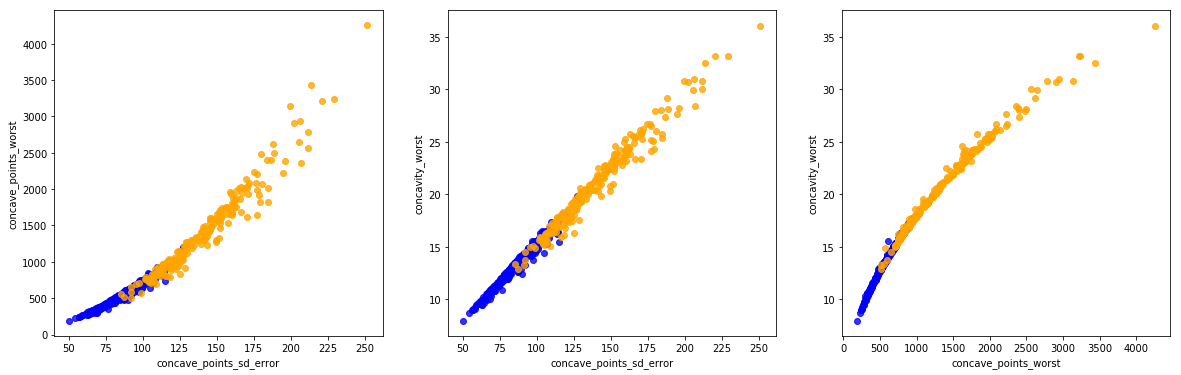

In [42]:
fig, axs = plt.subplots(1,3, figsize=(20, 6), facecolor='w', edgecolor='k')
colors = ['blue', 'orange']
lw = 2
pred_features = [('concave_points_sd_error', 'concave_points_worst'), ('concave_points_sd_error', 'concavity_worst'), 
                 ('concave_points_worst', 'concavity_worst')]

sub_num = 0
for f1, f2 in pred_features:
    for color, i, label in zip(colors, [0, 1], ['B','M']):
        sns.regplot(X.loc[y == i, f1], X.loc[y == i, f2], ax=axs[sub_num], scatter=True, fit_reg=False, color=color)
    sub_num = sub_num + 1

## Modeling using RandomForest and XGBoost

### 5-fold Cross evaluation

In [16]:
#Three kinds of classifiers
cassifiers = {'XGBoost': XGBClassifier(),
              'RandomForest': RandomForestClassifier()}

for name, clsf in cassifiers.items():
    print('Classifier {}:'.format(name))
    
    results = cross_val_score(clsf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %.3f (%.3f)" % (results.mean(), results.std()))

Classifier XGBoost:
Accuracy: 0.969 (0.021)
Classifier RandomForest:
Accuracy: 0.954 (0.026)


### Evaluation using split data

In [17]:
for name, clsf in cassifiers.items():
    
    clsf.fit(X_train, y_train)
    print('Classifier {}:'.format(name))
    
    y_train_pred = clsf.predict(X_train)
    print('Training accuracy: {}'.format(accuracy_score(y_train, y_train_pred)))

    y_pred = clsf.predict(X_test)
    print('Testing accuracy: {}'.format(accuracy_score(y_test, y_pred)))
    
    print('Confusion Matrix:')
    print(confusion_matrix(y_pred, y_test))
    
    print('Classification Report:')
    print(classification_report(y_pred, y_test))
    print('************************************************************')

Classifier XGBoost:
Training accuracy: 1.0
Testing accuracy: 0.9414893617021277
Confusion Matrix:
[[105   3]
 [  8  72]]
Classification Report:
             precision    recall  f1-score   support

          0       0.93      0.97      0.95       108
          1       0.96      0.90      0.93        80

avg / total       0.94      0.94      0.94       188

************************************************************
Classifier RandomForest:
Training accuracy: 0.9973753280839895
Testing accuracy: 0.9202127659574468
Confusion Matrix:
[[103   5]
 [ 10  70]]
Classification Report:
             precision    recall  f1-score   support

          0       0.91      0.95      0.93       108
          1       0.93      0.88      0.90        80

avg / total       0.92      0.92      0.92       188

************************************************************


### Feature importance

In [18]:
clsf_feature_importance = {}

#Finding the feature importance for each classifier
for name, clsf in cassifiers.items():
    clsf.fit(X_train, y_train)
    feature_importance = clsf.feature_importances_
    clsf_feature_importance.update({name:feature_importance})

#Sorting based on XGBoost feature importance
feature_importance_df = pd.DataFrame(clsf_feature_importance, index=feature_names).sort_values(by='XGBoost', ascending=False)

Feature Importance sorted by XGBoost values
                             XGBoost  RandomForest
concave_points_mean         0.123786      0.007265
smoothness_sd_error         0.123786      0.012823
concave_points_worst        0.097087      0.242057
fractal_dimension_mean      0.092233      0.107159
symmetry_mean               0.070388      0.001188
radius_sd_error             0.065534      0.003222
texture_sd_error            0.050971      0.000680
concave_points_sd_error     0.048544      0.162249
symmetry_worst              0.041262      0.066809
perimeter_sd_error          0.036408      0.095859
concavity_mean              0.036408      0.002349
concavity_worst             0.031553      0.052033
texture_mean                0.026699      0.069868
perimeter_mean              0.024272      0.085450
compactness_mean            0.024272      0.002313
texture_worst               0.021845      0.005594
fractal_dimension_sd_error  0.014563      0.007461
symmetry_sd_error           0.014563  

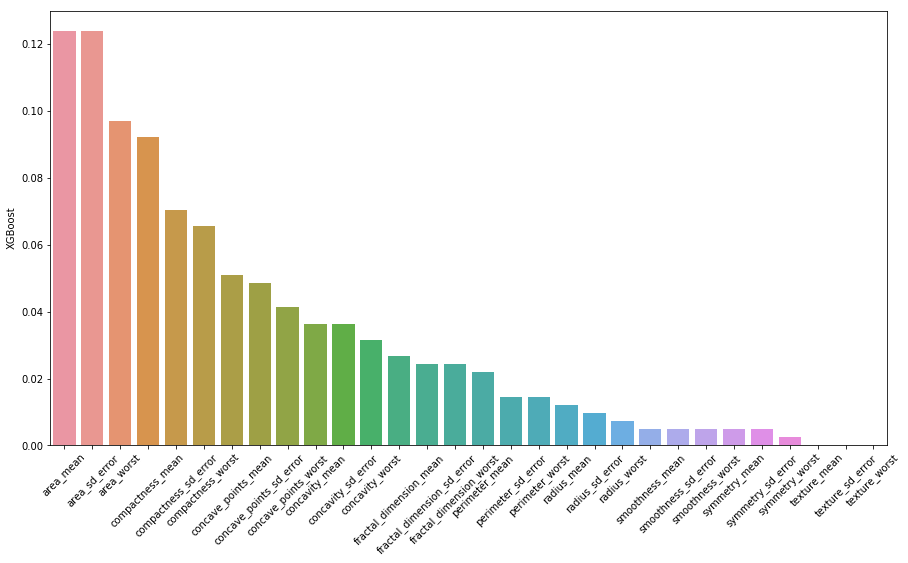

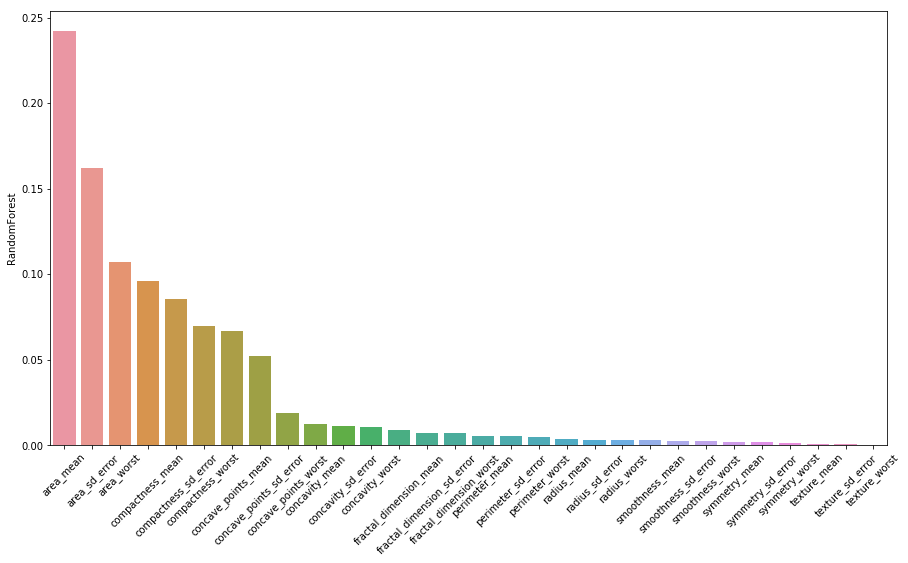

In [30]:
print('Feature Importance sorted by XGBoost values')
print(feature_importance_df)

plt.figure(figsize=(15,8))
sns.barplot(x=feature_names, y=feature_importance_df['XGBoost'])
plt.xticks(rotation=45)

plt.figure(figsize=(15,8))
sns.barplot(x=feature_names, y=feature_importance_df['RandomForest'].sort_values(ascending=False))
_ = plt.xticks(rotation=45)



Note that this feature importance ranking is not model agnostic so they are different and should be used with their respective classifier. We can see also some features, in the XGBoost, are not used such as concavity_st_error, radius_worst and fractal_dimension_worst.

## Future work 

As a future work, the following points can be considered:

1 - To try other types of classifiers such as Neural Network.

2 - To use feature reductions such as PCA and LDA to transform the features. Different combinations of these two techniques and classifiers can be constructed using Pipeline in sklearn.

3 - To perform feature selection combined with modeling. SelectKBest and Recursive Feature Selection (FSE) from sklearn can be used to analyse the performance with feature selection.

4 - In the above work, the default hyperparameters of the classifiers were used. However, it is recommended to tune these parameters in search for values that return better results. This can be done easily using the GridSearch feature in sklearn.

# Explanation

In this notebook a brief analysis and modeling were performed on the cancer dataset. EDA on the data revealed that there are a number of good predictive features for the two classes benign and malignant. The top three are concave_points_sd_error, concave_points_worst, concavity_worst.

Two classifiers (XGBoost, RandomForest) were investigated to predict the class of cancer. The two classifiers produced reasonably good results. The classifiers were selected because their results can be interpreted and also can be used to measure the importance of the features.

In general, XGBoost has performed slightly better than RandomForest with an accuracy of 0.969 on the 5-fold crossover validation.

The confusion matrix and the classification reports give more details of the performance of the classifier on the individual classes.

The precision value indicates if the classifier is confusing the benign as malignant. For the train-test split above, XGBoost has found true 72 malignant cases and added another 3 benign cases as malignant falsely. Therefore, 3 cases will be given a malignant treatment wrongly. Malignant Precision = 72/(72 + 3) = 0.96.

Recall value indicates the classifier is missing malignant cases. 8 malignant samples were classified wrongly as benign, which means that 8 malignant cases will not get the right malignant treatment. Malignant Recall = 72/(72 + 8) = 0.90.

The same explanation goes to the benign class.


# Part Two

In your notebook, move onto "Part 2" and log your responses accordingly. Please provide feedback for both of the sample student submissions provided below. Use the following guidelines to help structure your responses:

Code
Feel free to comment on style, library usage, or other improvements.

Methodology
Feel free to comment on the student's data setup, modeling methodology, and model evaluation.

Conceptual Understanding
Finally, feel free to add any suggestions or takeaways on how the student could continue to improve their understanding of these concepts.


### Sample 1

In [ ]:
#!/usr/bin/env python

import pandas as pd
import numpy as np
from sklearn import LinearRegression
from sklearn.cross_validation import cross_val_score

# Load data
d = pd.read_csv('../data/train.csv')


# Setup data for prediction
x1 = data.SalaryNormalized
x2 = pd.get_dummies(data.ContractType)

# Setup model
model = LinearRegression()

# Evaluate model
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
scores = cross_val_score(model, x2, x1, cv=1, scoring='mean_absolute_error')
print(scores.mean())

The sample code has a number of critical issues to be fixed:
    
1 - It is strongly advisable that the code to be tested and run before
submission. Executing the above code simply will return import error due to the line **from sklearn import LinearRegression**

2 - The code needs to follow better style to make it more readable. For example, use (X) for the data matrix and (y) for the label vector.

3 - Library imports are called one time at the beginning of the code. No need to call import two times for the same library

4 - When printing results that are numbers, provide a description text to explain what the number is about.

5 - For cross-validation testing, use more than three folds (cv>=3).

6 - Before any modeling, start with performing EDA (univariate and bivariate analysis). For linear regression check for correlations between the variables and check for outliers.

7 - Consider other metrics to evaluate the regression such R^2. 

8 - Check to make sure the model does not invalidate the assumptions of the linear regression modelling such randomness and normality of the error. 

## Sample 2

In [ ]:
#!/usr/bin/env python

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score

# Load data
data = pd.read_csv('../data/train.csv')


# Setup data for prediction
y = data.SalaryNormalized
X = pd.get_dummies(data.ContractType)

# Setup model
model = LinearRegression()

# Evaluate model
scores = cross_val_score(model, X, y, cv=5, scoring='mean_absolute_error')
print(scores.mean())

The sample code is good in general.

1 - When printing results that are numbers, provide a description text to explain what the number is about.

2 - Always start with a description of the data and its features.

3 - Before any modeling, start with performing EDA (univariate and bivariate analysis). For linear regression check for correlations between the variables and check for outliers.

4 - Consider other metrics to evaluate the regression such as R^2.

5 - Check to make sure the model does not invalidate the assumptions of the linear regression modelling such randomness and normality of the error. 